In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
from sklearn.utils import shuffle

In [6]:
from sklearn import metrics

In [54]:
#teraz sproboje z tego zrobic jakis dataset

In [55]:
#f,l=kolko_w_kolku()

In [56]:
#dataset = tf.data.Dataset.from_tensor_slices((f,l))

In [57]:
#BATCH_SIZE=100
#zbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)

In [58]:
#to jest dataset zaraz zastanowie sie jak go zapisac do pliku i z tego pliku odczytac a teraz jak go czytac?

In [59]:
#iterator = zbachowany.make_one_shot_iterator()

In [60]:
#f,l=iterator.get_next()

In [61]:
#with tf.Session() as sess:
#    for i in range(100):
#        sess.run(l)
    

In [62]:
#wrap_float64([5.55,6.85]) #swietnie

In [20]:


"""


Tym razem jak podajemy sciezke do folderu to ten plik ma juz byc pelen danych. 

bardzo nie lubi jak mu sie przerywa trening przy pomocy kernel interrrupt
pozniej nie chodza rozne rzeczy w takim przerwanym obiekcie
bo jak zaczyna trening to finalizuje graph co kolwiek to znacyzy, i 
jak konczy to chyba go odfinalizowywuje, ale jak przerwiemy to tego nie zrobi. nie do 
konca to rozumiem. wiec nie przerywamy treningu ani niczego inngo.

Na razie w pierwszym rzucie nie bedzie jeszcze danych typu kategorycznego.

To ma byc kompatybilne z klasa Io_tf_binary_general

__init__(nazwa_folderu,hidden_units,model_dir)
        to jest nazwa_folderu odnosi sie do folderu w ktorym pisala klasa
        Io_tf_binary_general czy cos
        hidden_units to jest lista po ile ma byc ukrytych unitsow. czyli nie podajemy rozmiaru
        danych wejsciowych ani wyjsciowych. idziemy od pierwszej (najblizszej inputu) do ostatniej
        model_dir to tam bedzie pisac swoje rzeczy nasz model
engineer_feature(self,f,slownik,typ,nazwa)
        dokladnie jak w tamtym dla io_tf_binary_general
make_model():
        to tworzy nasz model po tym jak podawalismy transformacje dla danych zgodnie z 
        engineer_feature() (taka jest metoda)
train 
        jest self explainatory. wydaje mi sie, ze to robi tak, ze kontynuuje
        trenowanie z miejsca w ktorym skonczylo
evaluate 
        to jest zwykla ewaluacja. tyle, ze mozna podac jako argument "folder" z ktorego pochodza nasze dane.
        ale ta funkcja zawsze dziala tak, ze po prostu traktuje 1 jako prawdziwe przypadki a 
        0 jako tlo
evaluate_jak_z_pracy(self,p0to1,p1to1,ile_take=10000,folder="")
        to robi takie szacowanie krzywej roc oraz auc wartosci jak w tej pracy. tutaj podajemy
        jako folder te nasze przypadki. ile_take to znaczy jak wiele przypadkow z tego datasetu
         z argumentu 'folder' nalezy wziasc. p0to1 to jest prawdopodoienstwo, ze przypadek oznaczony 
         0 jest tak na prawde 1 zas p1to1 to jest ze oznaczony jako 1 jest tak naprawde wlasnie rozpadem 
         czyli 1.zwraca jako pierwsze auc a potem jeszcze 3 listy zwiazane z rysowaniem krzywej roc.
         to znaczy liste jej xsow, jej ygrekow oraz jakim tresholdom te punkty krzywej roc odpowiadaja.
types()
        to jest zmienna tego obiektu ktora ma informacje o tym jakie feateres sa w naszym datasecie
        po tym jak zrobisz feature engineering to sie zmieni wynik podzialania .types()

        




"""
from sklearn import metrics
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import Io_tf_binary_general as io


class Dnn_uniwersalny:
    def __init__(self,nazwa_folderu,hidden_units,model_dir):
        self.not_compiled=True
        self.model_dir=model_dir
        self.nazwa_folderu=nazwa_folderu
        self.hidden_units=hidden_units
        self.wczytywacz=io.Io_tf_binary_general(nazwa_folderu,'r')
        
    def make_model(self):
        assert self.not_compiled
        my_feature_columns = []
        for k in self.wczytywacz.types().keys():
            if self.wczytywacz.types()[k][1]=='f':
                t=tf.float32
            else:
                t=tf.int32
            my_feature_columns.append(tf.feature_column.numeric_column(key=k,shape=\
                        (self.wczytywacz.types()[k][0],),dtype=t ))
        
        self.feature_columns=my_feature_columns
        
        def input_fn( batch_size=100,buffer_size=1000,folder=self.nazwa_folderu,one_epoch=False,czy_shuffle=True
                    ,czy_batch=True,take=False,ile_take=10000):
            """input function for training
            nazwy to lista nazw feature w kolejnosci wystepowania
            if one_epoch to tylko jedna epoka"""
            dataset=io.Io_tf_binary_general(folder,'r').read()
            if take:
                dataset=dataset.take(ile_take)
            if czy_shuffle:
                dataset=dataset.shuffle(buffer_size)
            if one_epoch:
                dataset=dataset.repeat(1)
            else:
                dataset=dataset.repeat()
            if czy_batch:
                dataset=dataset.batch(batch_size)
            return dataset
        self.input_fn=input_fn
        
        self.classifier = tf.estimator.DNNClassifier(
        feature_columns=self.feature_columns,
        hidden_units=self.hidden_units,
        model_dir=self.model_dir,
        n_classes=2)
        self.not_compiled=False
    def types():
        return self.wczytywacz.types()
    def engineer_feature(self,f,slownik,typ,nazwa):
        assert self.not_compiled
        return self.wczytywacz.engineer_feature(f,slownik,typ,nazwa)
    def train(self,batch_size=128,buffer_size=1000,steps=3000):
        self.classifier.train(
        input_fn=lambda:self.input_fn( batch_size,buffer_size),
        steps=steps)
    def evaluate(self,batch_size=128,buffer_size=1000,steps=1000,folder=""):
        if folder=="":
            folder=self.nazwa_folderu
        self.last_eval_result = self.classifier.evaluate(
        input_fn=lambda:self.input_fn( batch_size,buffer_size,folder=folder),
        steps=steps)
        return self.last_eval_result
    """
    def input_fn_new_graph( folder,batch_size=100,buffer_size=1000,one_epoch=False,czy_shuffle=True
                    ,czy_batch=True):
        
        g = tf.Graph()
        with g.as_default():
            dataset=io.Io_tf_binary_general(folder,'r').read()
            if czy_shuffle:
                dataset=dataset.shuffle(buffer_size)
            if one_epoch:
                dataset=dataset.repeat(1)
            else:
                dataset=dataset.repeat()
            if czy_batch:
                dataset=dataset.batch(batch_size)
            return dataset
            """
    def _labelki( folder,ile_take):
        """pomocnicza funkcja ktora zwraca generator labelkow przypadkow"""
        #g = tf.Graph()
        #with g.as_default():
        dataset=io.Io_tf_binary_general(folder,'r').read().take(ile_take)

        dataset=dataset.repeat(1)
        dane=dataset
        iterator = dane.make_one_shot_iterator()
        para=iterator.get_next()
        def wyrzut():
            with tf.Session() as sess2:
                while True:
                    try:
                        yield sess2.run(para)[1]
                    except:
                        break
        return wyrzut()
            
            
    
    def evaluate_jak_z_pracy(self,p0to1,p1to1,ile_take=10000,folder=""):
        def generator_of_predictions_and_labels(self,batch_size=128,folder="",ile_take=10000):
            if folder=="":
                folder=self.nazwa_folderu   
            return (self.classifier.predict(input_fn=
               lambda:self.input_fn(batch_size,folder=folder,one_epoch=True,czy_shuffle=False,take=True,ile_take=ile_take)),
                    Dnn_uniwersalny._labelki(folder,ile_take)  )
        #tu jest pewien problem. jak sie odpali ten generator rzeczy wynikajacych z predict to\
        #dopuki sie nie wykona nie da sie nic  robic na grafie. bo jest chwilowo finalized. wiec
        #najpierw odczytam sobie jedne rzeczy a potem drugie. nie moge zrobic zip tych 
        # 2 generatorow. dlatego uzywam funkcji take ktora ograniczy nam to jak duzo danych dostaniemy
        def ta_praw(a):
            wyrzut=[]
            for i in a:
                wyrzut.append(i['probabilities'][1])
            return wyrzut


        def benchmark(gen_z_estimatora,gen_ground_truth_mixed_class,p0to1,p1to1):
            """p0to1 to prawdopodobienstow, ze jak cos ma labelke 0 to to jest 1"""
            #przez wyniki rozumiem liczbe ktora im jest wieksza tym bardziej estymator mysli ze to jest 1
            probabilities_of_being_1=ta_praw(gen_z_estimatora)
            true_class_identity=list(gen_ground_truth_mixed_class)
            #przez class rozumiem tu ta mieszanine z prawdopodpbienstwem

            assert len(probabilities_of_being_1)==len(true_class_identity)

            fpr, tpr, thresholds = metrics.roc_curve(true_class_identity
                        , probabilities_of_being_1, pos_label=1)
            eps_s_list=[]
            eps_b_list=[]
            for i in range(len(fpr)):
                odw=np.linalg.inv(np.array([[p0to1,1-p0to1],[p1to1,1-p1to1]]))
                epss_epsb=np.matmul(odw,np.array([[fpr[i]],[tpr[i]]]))
                eps_s,eps_b=epss_epsb
                eps_s_list.append(eps_s)
                eps_b_list.append(eps_b)
            return eps_s_list,eps_b_list,thresholds
        a,b=generator_of_predictions_and_labels(self,batch_size=128,folder=folder,ile_take=10000)
        eps_s,eps_b,thresholds=benchmark(a,b,p0to1,p1to1)
        auc=metrics.auc(eps_b,eps_s,True)
        print("auc wynosi "+str(auc))
        plt.clf()
        plt.scatter(eps_b,eps_s)
        plt.xlabel("eps_b")
        plt.ylabel("eps_s")
        return auc,eps_s,eps_b,thresholds
    
    
    
    
    
    
        
        
        
    
        

In [21]:
#Ta linijka zaklada, ze zrobilismy plik dane_treningowe2 wedlug Io_tf_binary

In [22]:
model=Dnn_uniwersalny("weak_train",[10],"weak_estimator")

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}


In [23]:
model.make_model()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'weak_estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f913415ab38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [24]:
model.train()

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from weak_estimator/model.ckpt-90000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 90001 into weak_estimator/model.ckpt.
INFO:tensorflow:loss = 89.98893, step = 90001
INFO:tensorflow:global_step/sec: 174.198
INFO:tensorflow:loss = 87.24575, step = 90101 (0.575 sec)
INFO:tensorflow:global_step/sec: 204.613
INFO:tensorflow:loss = 85.44652, step = 90201 (0.489 sec)
INFO:tensorflow:global_step/sec: 194.152
INFO:tensorflow:loss = 88.53906, step = 90301 (0.516 sec)
INFO:tensorflow:global_step/sec: 20

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from weak_estimator/model.ckpt-93000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
auc wynosi 0.8003289371518156


0.8003289371518156

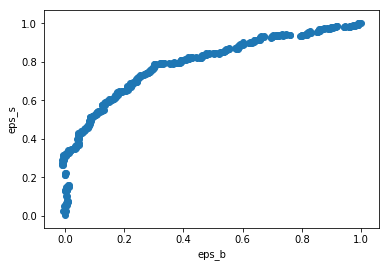

In [28]:
a=model.evaluate_jak_z_pracy(0.2,0.8,folder="weak_validate")
a[0]

In [29]:
model.evaluate(folder="weak_true")

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-20-14:34:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from weak_estimator/model.ckpt-93000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-05-20-14:34:46


{'accuracy': 0.719,
 'accuracy_baseline': 0.525,
 'auc': 0.78523517,
 'auc_precision_recall': 0.8141674,
 'average_loss': 0.61301535,
 'label/mean': 0.525,
 'loss': 78.465965,
 'precision': 0.73552126,
 'prediction/mean': 0.5033703,
 'recall': 0.72571427,
 'global_step': 93000}

In [65]:
a,b=model.generator_of_predictions_and_labels()

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}


In [ ]:
b

In [33]:
next(a)

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from weak_estimator/model.ckpt-51000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'logits': array([0.35058486], dtype=float32),
 'logistic': array([0.5867594], dtype=float32),
 'probabilities': array([0.4132406, 0.5867594], dtype=float32),
 'class_ids': array([1]),
 'classes': array([b'1'], dtype=object)}

In [34]:
for i in a:
    'costam'

In [35]:
for i in b:
    print(i)

0
0
0
1
0
1
1
0
1
0
0
1
0
1
0
0
0
0
0
1
0
0
0
1
0
0
1
0
1
0
1
0
0
1
0
0
0
1
0
1
0
0
1
0
0
0
1
0
0
1
0
1
0
0
1
1
0
1
1
1
1
0
0
1
0
1
0
0
0
1
1
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
0
1
0
1
0
0
1
0
0
1
0
1
1
1
1
0
0
1
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
1
0
0
0
1
1
1
1
1
0
1
1
0
1
1
1
1
1
0
0
0
1
1
1
0
0
1
0
1
0
0
1
0
1
1
1
0
1
1
0
0
1
1
1
1
0
0
0
1
0
0
0
0
1
0
0
0
1
1
1
1
1
1
1
1
1
0
0
0
0
1
1
1
0
0
1
0
1
1
0
1
1
1
1
0
0
0
1
1
0
1
1
0
1
0
1
0
0
0
0
1
0
1
0
1
1
1
1
1
1
1
0
0
1
0
0
0
0
0
1
1
1
0
0
0
1
0
0
0
1
1
1
1
0
1
0
1
0
1
1
1
0
0
1
1
1
0
1
1
1
0
1
1
0
0
1
1
1
0
1
0
1
0
0
0
1
1
0
1
1
1
0
1
0
0
1
0
0
1
1
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
1
1
1
0
0
0
1
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
1
1
1
1
0
0
1
0
0
1
1
0
1
1
1
1
1
0
1
1
0
1
1
0
1
0
1
0
0
1
0
0
1
1
0
1
0
0
1
0
0
0
1
0
1
0
1
0
1
1
0
1
0
0
1
1
1
1
0
1
1
1
1
1
1
0
0
1
1
0
1
0
0
0
1
1
0
1
0
0
0
1
1
0
0
0
1
0
1
0
1
0
1
0
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
0
1
1
1
0
1
1
0
1
1
0
1
1
0
1
0
1
0
1
1
1
1
0
1
0
0
1
0
0
1
0
0
1
0


1
0
1
1
1
1
0
1
0
0
0
0
0
0
0
1
0
1
1
1
1
1
0
1
1
0
1
1
1
0
0
0
0
1
1
0
0
0
0
0
0
1
1
0
1
1
1
0
0
1
1
0
1
1
1
1
0
0
0
0
1
1
1
1
1
1
1
0
1
0
1
0
0
1
0
1
1
1
0
1
1
1
0
1
1
0
1
0
1
0
1
0
0
1
1
1
0
0
1
1
1
0
0
0
1
0
1
0
1
0
1
0
1
1
0
1
1
1
0
1
1
0
0
1
0
1
0
0
1
0
0
1
1
1
0
0
0
0
0
0
0
1
1
0
0
1
0
1
1
1
1
1
0
0
0
1
0
1
0
0
1
0
1
0
1
0
0
0
1
0
1
1
0
0
1
1
0
0
1
0
0
1
1
0
0
0
1
0
1
0
0
1
0
1
0
0
0
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
1
1
1
0
0
0
1
0
0
1
1
0
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
1
0
1
1
1
0
0
1
0
1
1
1
1
1
0
0
0
1
0
0
1
1
1
0
1
0
0
1
1
1
0
1
1
0
0
0
0
1
0
0
1
1
0
1
0
0
1
1
0
0
1
0
1
1
0
0
0
0
1
0
0
1
1
0
0
1
1
0
1
1
0
0
0
1
1
1
0
1
1
1
0
1
1
1
0
0
0
1
1
1
1
0
0
1
1
1
0
0
1
0
0
1
0
0
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
1
0
0
1
1
1
0
0
1
0
0
0
0
0
1
1
0
1
1
0
0
0
0
0
1
0
0
1
0
1
1
0
0
1
1
1
1
1
0
1
1
0
1
1
1
0
0
1
0
1
1
1
0
1
1
0
1
0
1
0
0
1
1
0
0
1
0
0
0
0
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
0
0
1
1
1
0
0
1
0
1
1
1
1
0
0
0
1
1
0
1
1
0
0
1
0
1
0
1
1
1
1
0
1
1
1
1
0
0
1
0
1
0
1
0
0
0


0
0
1
1
1
1
0
1
0
0
1
1
1
1
1
1
1
0
1
1
1
0
0
1
0
0
0
0
1
0
1
1
0
1
1
0
1
0
0
0
1
1
0
0
1
0
0
0
1
0
0
0
1
1
0
1
0
1
0
0
0
0
1
1
1
0
1
1
0
1
1
0
1
1
0
0
0
1
1
1
0
1
1
1
1
0
0
1
0
0
1
0
0
1
1
1
0
1
1
1
1
0
1
0
1
0
0
1
1
0
1
1
0
1
0
0
0
1
1
1
0
0
0
1
0
1
1
1
1
1
1
0
1
0
1
1
0
0
1
1
1
0
0
0
0
1
0
1
0
0
0
0
0
1
0
1
1
0
1
1
1
0
0
0
1
0
0
0
0
1
0
1
1
0
1
0
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
0
1
1
1
1
0
1
0
0
0
0
1
1
0
0
1
1
0
1
1
0
1
0
1
0
0
0
1
1
1
1
0
1
1
0
1
1
1
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
1
0
1
1
1
0
0
0
1
1
0
1
1
1
0
1
0
0
0
1
1
0
0
1
0
1
0
0
0
1
1
0
1
1
0
1
1
1
0
1
0
1
0
0
0
0
1
1
1
1
0
1
0
0
1
0
1
0
0
1
0
0
0
1
0
1
0
0
1
1
1
0
0
0
1
0
1
1
1
1
0
1
1
0
0
1
1
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
0
1
1
0
0
0
0
1
0
0
0
1
0
1
0
1
1
1
1
0
0
0
1
1
1
1
1
1
0
0
1
1
0
0
0
1
1
1
0
0
0
0
1
0
0
1
1
0
0
1
0
0
0
1
1
1
0
0
1
1
0
0
1
1
0
1
0
1
0
1
0
1
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
1
0
0
1
1
0
1
1
1
1
0
0
1
0
0
1
1
0
1
1
0
0
1
0
0
0
0
0
0
1
1
1
1
0
0
1
0
0
1
0
1
1
1
0
1
0
1
1
0
1
0
1
1
1
1
0
1
0
0
1
1
1
0
0
0


In [64]:
def ta_praw(a):
    wyrzut=[]
    for i in a:
        wyrzut.append(i['probabilities'][1])
    return wyrzut


def benchmark(gen_z_estimatora,gen_ground_truth_mixed_class,p0to1,p1to1):
    """p0to1 to prawdopodobienstow, ze jak cos ma labelke 0 to to jest 1"""
    #przez wyniki rozumiem liczbe ktora im jest wieksza tym bardziej estymator mysli ze to jest 1
    probabilities_of_being_1=ta_praw(gen_z_estimatora)
    true_class_identity=list(gen_ground_truth_mixed_class)
    #przez class rozumiem tu ta mieszanine z prawdopodpbienstwem
    
    assert len(probabilities_of_being_1)==len(true_class_identity)
    
    fpr, tpr, thresholds = metrics.roc_curve(true_class_identity
                , probabilities_of_being_1, pos_label=1)
    eps_s_list=[]
    eps_b_list=[]
    for i in range(len(fpr)):
        odw=np.linalg.inv(np.array([[p0to1,1-p0to1],[p1to1,1-p1to1]]))
        epss_epsb=np.matmul(odw,np.array([[fpr[i]],[tpr[i]]]))
        eps_s,eps_b=epss_epsb
        eps_s_list.append(eps_s)
        eps_b_list.append(eps_b)
    return eps_s_list,eps_b_list,tresholds
        
    

In [66]:
eps_s,eps_b,tresholds=benchmark(a,b,0.1,0.9)

{'pierwsza': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'inna_wlasnosc': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from weak_estimator/model.ckpt-51000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [52]:
aa,bb=np.array([1,2])

In [53]:
aa

1

In [68]:
metrics.auc(eps_b,eps_s,True)

0.6570695446754657

In [69]:
import matplotlib.pyplot as pl
%matplotlib inline

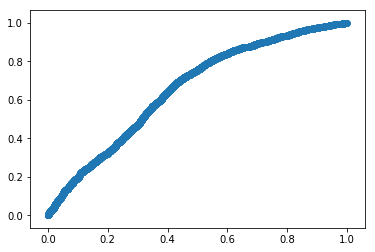

In [72]:
plt.clf()
plt.scatter(eps_b,eps_s)

In [ ]:
model.evaluate(folder="weak_true")

In [ ]:
#wiec czegos sie nauczyl ewidentnie

In [ ]:
a=model.generator_of_predictions()

In [ ]:
a

In [ ]:
next(a)

In [ ]:
i=0
for p in a:
    i+=1
    if i>10:
        break
    print(p)
    print("\n")